<a href="https://www.kaggle.com/code/simonebrazzi/credit-score?scriptVersionId=210970434" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import time
import shap

from datetime import date
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from xgboost import DMatrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
class Config():

  def __init__(self):
    """
    Initialization calss.
    """

    self.path="/kaggle/working/"
    self.file="/kaggle/input/credit-scoring/credit_scoring.csv"
    self.model_result_path="/kaggle/working/"
    self.random_state=42
    self.col_binary = ['code_gender', 'flag_own_car', 'flag_own_realty']
    self.col_ordinal = ["name_income_type", "name_education_type", "name_family_status", "name_housing_type", "occupation_type"]
    self.col_numeric = ['cnt_children', 'amt_income_total', 'cnt_fam_members']
    self.features = self.col_binary + self.col_ordinal + self.col_numeric

config = Config()

# Import

In [3]:
df = pd.read_csv(config.file)
df.columns = df.columns.str.lower()
df["id"] = df.id.astype(int)

In [4]:
df = df[df.id != 6392180]
df = df[~df.occupation_type.isna()]

# Split

In [5]:
x = df[config.features]
y = df.target

xtrain, xtest, ytrain, ytest = train_test_split(
    x,
    y,
    test_size = .2,
    stratify = y,
    random_state=config.random_state
)

# Decision Tree Classifier

In [6]:
ohe = OneHotEncoder(drop='if_binary', sparse_output=False)
oe = OrdinalEncoder().set_output(transform='pandas')
ss = StandardScaler()
dtc = DecisionTreeClassifier(class_weight="balanced")

preprocessor = ColumnTransformer(
  transformers=[
    ("binary_encoder", ohe, config.col_binary),
    ("ordinal_encoder", oe, config.col_ordinal),
    ("standard_scaler", ss, config.col_numeric)
    ],
    remainder='passthrough'
    )

pipe_dtc = Pipeline(
  steps=[
    ("preprocessor", preprocessor),
    ("dtc", dtc)
    ]
    )

param_grid_dtc = {
  "dtc__criterion" : ["gini", "entropy", "log_loss"],
  "dtc__splitter" : ["best", "random"],
  "dtc__max_depth" : [1, 2, 5, 10, 15]
}

scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

grid_search_dtc = GridSearchCV(
    estimator=pipe_dtc,
    param_grid=param_grid_dtc,
    cv=7,
    scoring=scoring,
    refit="f1",  # This will refit the model using the accuracy metric
    n_jobs=-1
)

## Fit

gs_dtc = grid_search_dtc.fit(xtrain, ytrain)

## Pickle

with open(config.model_result_path + "credit_score_grid_search_dtc_f1.pkl", "wb") as f:
    pickle.dump(gs_dtc, f)

In [7]:
with open(config.model_result_path + "credit_score_grid_search_dtc_f1.pkl", "rb") as f:
  gs_dtc = pickle.load(f)

dtc_model = gs_dtc.best_estimator_

## Predict & Classification Report

In [8]:
ypred_dtc = dtc_model.predict(xtest)
cr = classification_report(
  ytest,
  ypred_dtc,
  target_names=['0', '1'],
  digits=4,
  output_dict=True
  )
df_cr = pd.DataFrame.from_dict(cr).reset_index()
df_cr

,index,0,1,accuracy,macro avg,weighted avg
0,precision,0.989899,0.303360,0.763043,0.646629,0.916436
1,recall,0.742224,0.936792,0.763043,0.839508,0.763043
2,f1-score,0.848354,0.458307,0.763043,0.653330,0.806617
3,support,41986.000000,5031.000000,0.763043,47017.000000,47017.000000


# Random Forest Classifier

In [9]:
# classifier
rfc = RandomForestClassifier(class_weight="balanced")
# pipeline
pipe_rfc = Pipeline(
  steps=[
    ("preprocessor", preprocessor),
    ("rfc", rfc)
    ]
    )
# parameters
param_dist_rfc = {
    'rfc__n_estimators': [50, 75, 100],
    'rfc__max_depth': [5, 10, 15],
    'rfc__min_samples_split': [5, 10]
}
# grid search
grid_search_rfc = GridSearchCV(
    estimator=pipe_rfc,
    param_grid=param_dist_rfc,
    cv=7,
    scoring=scoring,
    refit="f1",
    n_jobs=-1
)

## Fit

start_time = time.time()
rs_rfc = grid_search_rfc.fit(xtrain, ytrain)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")
print(f"Elapsed time: {elapsed_time / 60} minutes")

## Pickle

with open(config.model_result_path + "credit_score_grid_search_rfc_f1.pkl", "wb") as f:
  pickle.dump(rs_rfc, f)

In [10]:
with open(config.model_result_path + "credit_score_grid_search_rfc_f1.pkl", "rb") as f:
  gs_rfc = pickle.load(f)

rfc_model = gs_rfc.best_estimator_

## Predict

In [11]:
ypred_rfc = rfc_model.predict(xtest)
cr_rfc = classification_report(
  ytest,
  ypred_rfc,
  # target_names=config.labels,
  digits=4,
  output_dict=True
  )
df_cr_rfc = pd.DataFrame.from_dict(cr_rfc).reset_index()
df_cr_rfc

,index,0,1,accuracy,macro avg,weighted avg
0,precision,0.992220,0.324002,0.782547,0.658111,0.920718
1,recall,0.762468,0.950109,0.782547,0.856289,0.782547
2,f1-score,0.862303,0.483219,0.782547,0.672761,0.821740
3,support,41986.000000,5031.000000,0.782547,47017.000000,47017.000000


# XGBoost Classifier

## Pipeline

In [12]:
# classifier
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
xgb = XGBClassifier(
    n_jobs=-1,
    enable_categorical=True,
    scale_pos_weight=scale_pos_weight
)
# pipeline
pipe_xgb = Pipeline(
  steps=[
    ("preprocessor", preprocessor),
    ("xgb", xgb)
    ]
    )
# parameters
param_dist_xgb = {
  "xgb__n_estimators" : [100, 150, 200, 300],
  "xgb__max_depth" : [3, 5, 7, 10],
  "xgb__learning_rate" : [0.1, 0.1, 0.01, 0.0001],
  "xgb__subsample": [0.7, 0.8, 0.9],
  "xgb__colsample_bytree": [0.7, 0.8, 0.9],
  "xgb__gamma": [0, 0.1],
  "xgb__alpha": [0, 0.1],  # Adding slight L1 regularization for simplicity
  "xgb__lambda": [1, 2]    # Adding slight L2 regularization for stability
}
# scoring
scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "roc_auc": "roc_auc"
}
# random search cv
random_search_xgb = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_dist_xgb,
    n_iter=30,  # Set the number of parameter combinations to try
    cv=7,
    scoring=scoring,
    refit="f1",
    n_jobs=-1
    )

## Fit

start_time = time.time()
rs_xgb = random_search_xgb.fit(xtrain, ytrain)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")
print(f"Elapsed time: {elapsed_time / 60} minutes")

## Pickle

with open(config.model_result_path + "credit_score_random_search_xgb_f1.pkl", "wb") as f:
  pickle.dump(rs_xgb, f)

In [13]:
with open(config.model_result_path + "credit_score_random_search_xgb_f1.pkl", "rb") as f:
  rs_xgb = pickle.load(f)

xgb_model = rs_xgb.best_estimator_

## Predict

In [14]:
ypred_xgb = xgb_model.predict(xtest)
cr_xgb = classification_report(
  ytest,
  ypred_xgb,
  # target_names=config.labels,
  digits=4,
  output_dict=True
  )
df_cr_xgb = pd.DataFrame.from_dict(cr_xgb).reset_index()
df_cr_xgb

[09:18:05] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



,index,0,1,accuracy,macro avg,weighted avg
0,precision,0.993049,0.355486,0.810026,0.674268,0.924827
1,recall,0.792812,0.953687,0.810026,0.873250,0.810026
2,f1-score,0.881705,0.517919,0.810026,0.699812,0.842778
3,support,41986.000000,5031.000000,0.810026,47017.000000,47017.000000


# Plot

In [15]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel, wilcoxon
import matplotlib.pyplot as plt

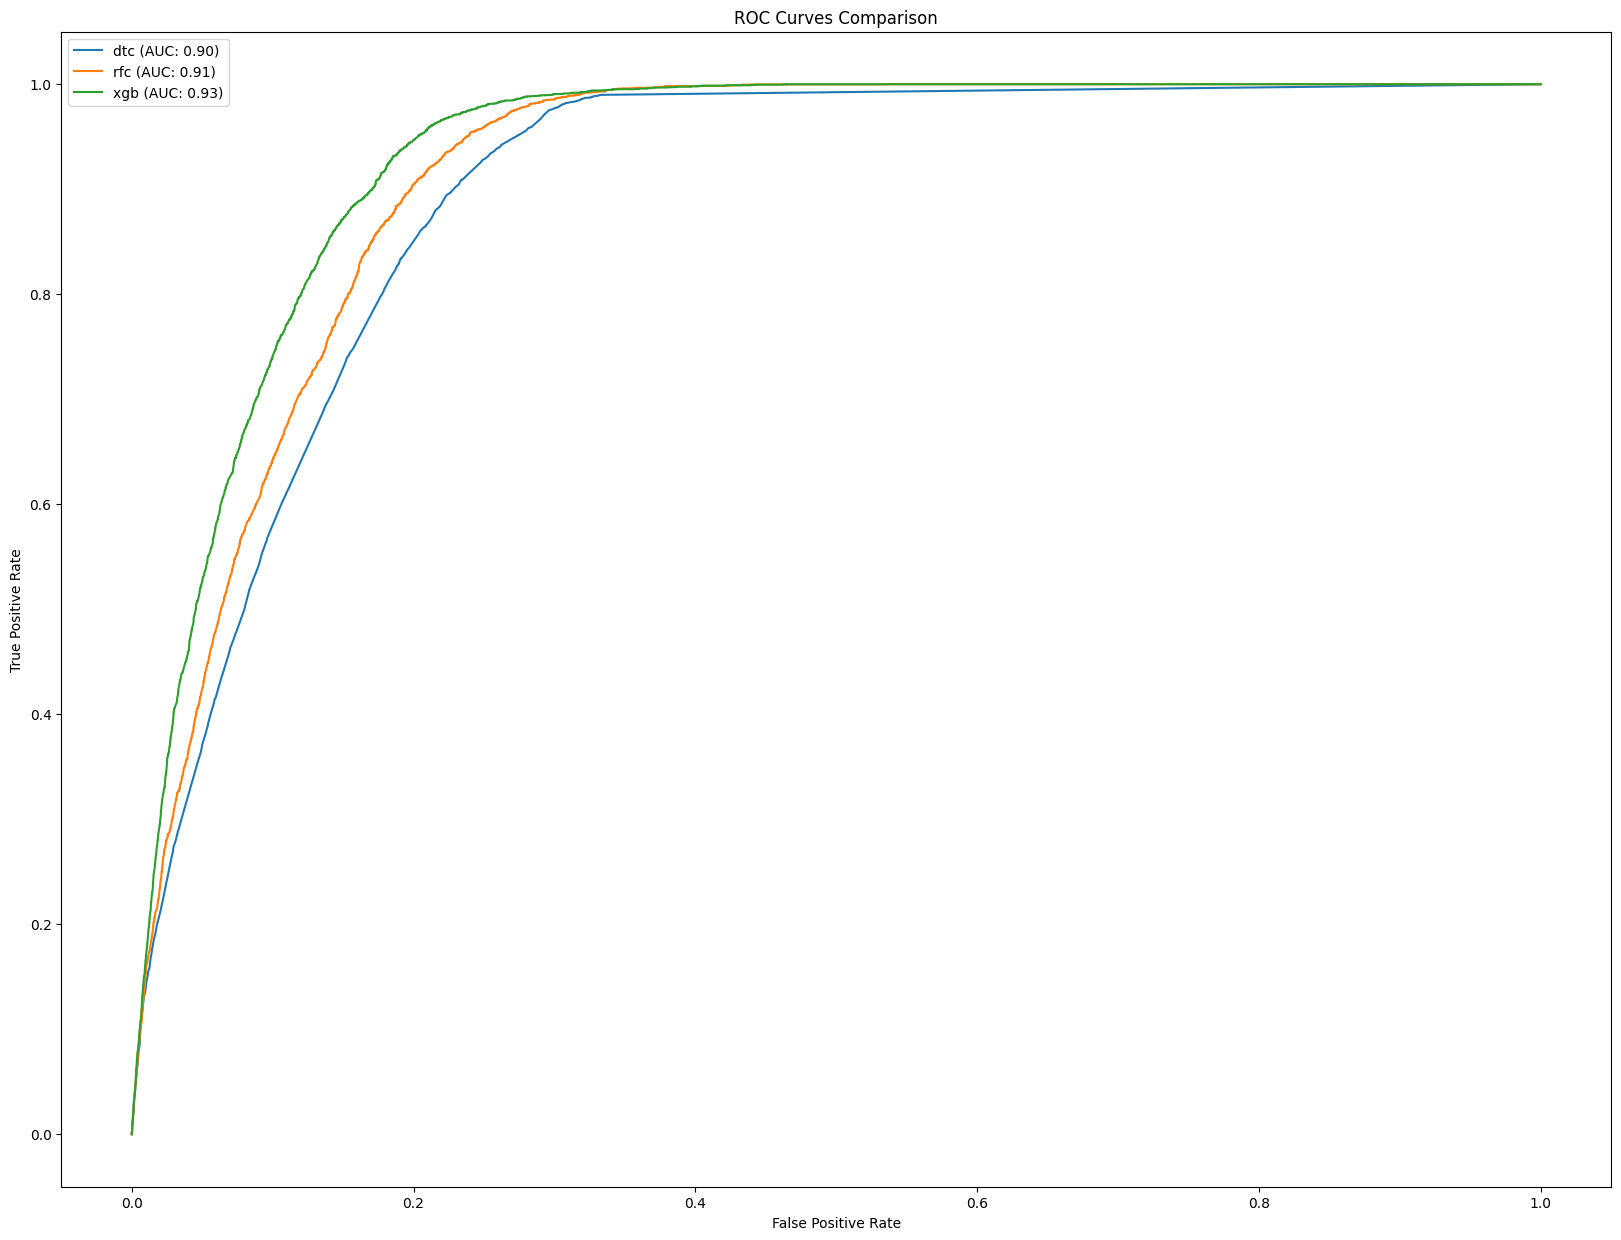

In [16]:
plt.figure(figsize=(20, 15))

model_names = ["dtc", "rfc", "xgb"]
models = [dtc_model, rfc_model, xgb_model]

for i, model in enumerate(models):
    fpr, tpr, _ = roc_curve(ytest, model.predict_proba(xtest)[:, 1])
    plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC: {roc_auc_score(ytest, model.predict_proba(xtest)[:, 1]):.2f})')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.show()

# Explainability

In [17]:
preprocessor = xgb_model.named_steps["preprocessor"]
xgb_clf = xgb_model.named_steps["xgb"]
idx = [15454, 1284, 30305]

In [18]:
xtest.iloc[idx[0]]

code_gender                                        M
flag_own_car                                       Y
flag_own_realty                                    Y
name_income_type                             Working
name_education_type    Secondary / secondary special
name_family_status                           Married
name_housing_type                    Co-op apartment
occupation_type                             Laborers
cnt_children                                       1
amt_income_total                            216000.0
cnt_fam_members                                  3.0
Name: 226874, dtype: object

In [19]:
# retain features name
xtrain_processed = preprocessor.transform(xtrain)
xtrain_processed = pd.DataFrame(xtrain_processed, columns=config.features)
# retain features name
xtest_processed = preprocessor.transform(xtest)
xtest_processed = pd.DataFrame(xtest_processed, columns=config.features)
# retain features name
xgb_clf.get_booster().feature_names = config.features
# convert to DMatrix
dtrain = DMatrix(xtrain_processed, label=ytrain)
dtest = DMatrix(xtest_processed, label=ytest)
# usefol idxs
idx = [15454, 1284, 30305]

x_processed = preprocessor.transform(x)

## Features importance

<Axes: title={'center': 'Feature Importance by Gain'}, xlabel='F score', ylabel='Features'>

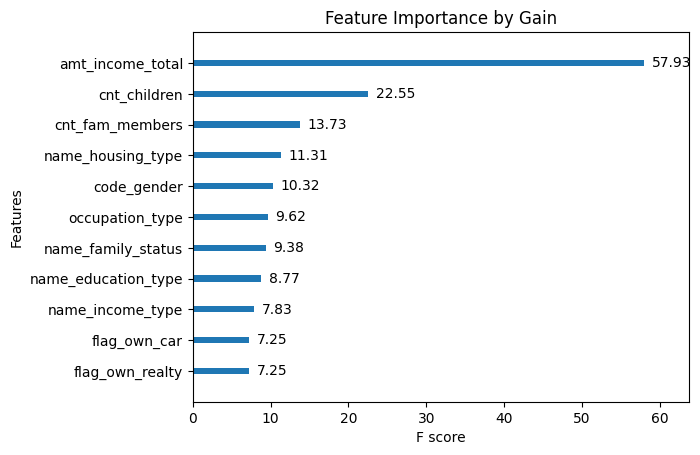

In [20]:
from xgboost import plot_importance

plot_importance(
    booster=xgb_clf.get_booster(),
    grid=False,
    importance_type="gain",
    title="Feature Importance by Gain",
    values_format="{v:.2f}"
)

##  Explain predictions

In [21]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(x_processed)

In [22]:
with open(config.model_result_path + "shap_values.pkl", "wb") as f:
  pickle.dump(rs_xgb, f)

In [ ]:
with open(config.model_result_path + "shap_values.pkl", "rb") as f:
  shap_values = pickle.load(f)

## Visualize a single prediction

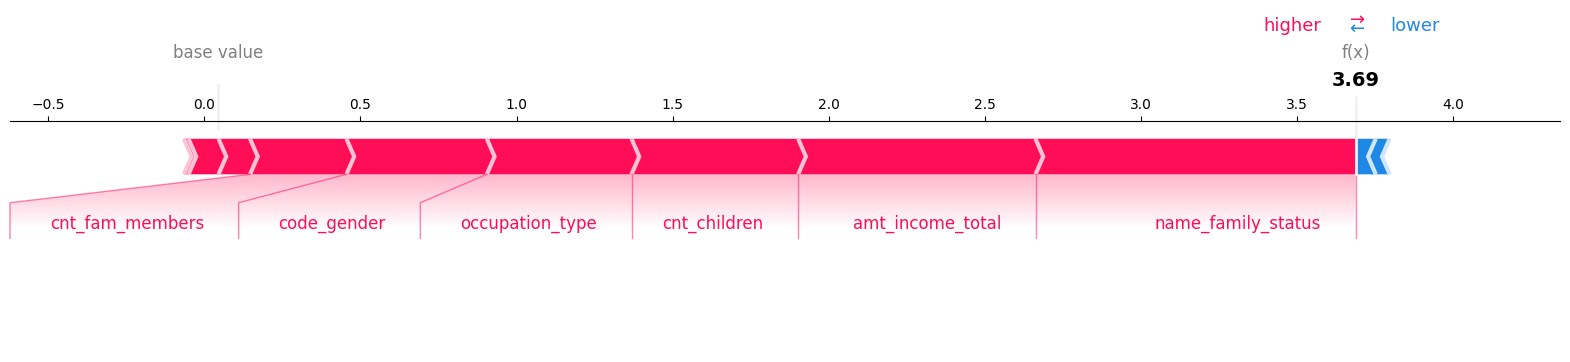

In [23]:
shap.plots.force(
    base_value=explainer.expected_value,
    shap_values=shap_values[idx[0], :],
    # features=None,
    feature_names=config.features,
    # out_names=None,
    # link='identity', # "logit"
    plot_cmap='RdBu',
    matplotlib=True,
    show=True
)